## Imports & Setup

In [1]:
import os
import random
import numpy as np
import pandas as pd
import pydicom
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    confusion_matrix
)

from torchvision import transforms
from transformers import ViTForImageClassification

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Dataset Class & Transforms

In [2]:
class CustomMedicalImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            dcm = pydicom.dcmread(self.image_paths[idx])
            arr = dcm.pixel_array.astype(np.float32)
            img = Image.fromarray((arr/arr.max()*255).astype(np.uint8)).convert("RGB")
            if self.transform:
                img = self.transform(img)
            label = torch.tensor(self.labels[idx], dtype=torch.float32)
            return img, label
        except Exception as e:
            print(f"Error reading {self.image_paths[idx]}: {e}")
            raise e

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(0.2,0.2,0.2,0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

## Load Paths & Labels

In [3]:
image_dir = "/mnt/e/ecs289l/mimic-cxr-download/imageData/"
all_paths = []
for root, _, files in os.walk(image_dir):
    for f in files:
        if f.endswith(".dcm"):
            all_paths.append(os.path.join(root, f))

meta = pd.read_csv(
    "../download_data/metadata/edema+pleural_effusion_samples_v2.csv",
    dtype={'study_id': str}
)
meta['study_id'] = 's' + meta['study_id']
label_map = meta.set_index('study_id')[['edema','effusion']].to_dict(orient='index')

paths, labels = [], []
for p in all_paths:
    sid = os.path.basename(os.path.dirname(p))
    if sid in label_map:
        paths.append(p)
        labels.append([label_map[sid]['edema'], label_map[sid]['effusion']])
labels = np.array(labels)
print(f"Total samples: {len(paths)}")

Total samples: 7199


## Split

In [4]:
train_data, test_val_data, train_labels, test_val_labels = train_test_split(
    paths, labels, test_size=0.3, random_state=SEED, shuffle=True, stratify=labels
)
test_data, val_data, test_labels, val_labels = train_test_split(
    test_val_data, test_val_labels, test_size=1/3, random_state=SEED, shuffle=True, stratify=test_val_labels
)

print("Train / Val / Test sizes:", len(train_data), len(val_data), len(test_data))

train_ds = CustomMedicalImageDataset(train_data, train_labels, transform=transform)
val_ds = CustomMedicalImageDataset(val_data, val_labels, transform=transform)
test_ds = CustomMedicalImageDataset(test_data, test_labels, transform=transform)

Train / Val / Test sizes: 5039 720 1440


## Training

In [16]:
from tqdm import tqdm

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for imgs, labs in tqdm(loader, desc="Training"):
        imgs, labs = imgs.to(device), labs.to(device)
        optimizer.zero_grad()
        logits = model(imgs).logits
        loss = criterion(logits, labs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for imgs, labs in tqdm(loader, desc="Validation"):
            imgs, labs = imgs.to(device), labs.to(device)
            logits = model(imgs).logits
            total_loss += criterion(logits, labs).item()
    return total_loss / len(loader)


def run_training(combo, train_loader, val_loader, model, device):
    # Unpack combo
    dp, wd, lr = combo['dropout_rate'], combo['weight_decay'], combo['learning_rate']
    ne, pt  = combo['num_epochs'], combo.get('patience', 5)

    # Configure model, loss, optimizer
    model.config.classifier_dropout = dp
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)

    best_val_loss = float('inf')
    no_improve = 0

    for epoch in range(1, ne+1):
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss = validate_epoch(model, val_loader, criterion, device)
        print(f"Epoch {epoch}/{ne}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= pt:
                print(f"Early stopping at epoch {epoch}")
                break

## Evaluation

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt

def evaluate_model(model, test_loader, device):
    model.eval()
    all_labels, all_probs = [], []
    with torch.no_grad():
        for imgs, labs in test_loader:
            imgs = imgs.to(device)
            logits = model(imgs).logits.cpu().numpy()
            probs = torch.sigmoid(torch.tensor(logits)).numpy()
            all_probs.append(probs)
            all_labels.append(labs.numpy())
    all_probs  = np.vstack(all_probs)
    all_labels = np.vstack(all_labels)
    preds = (all_probs >= 0.5).astype(int)

    metrics = {}
    for i, name in enumerate(['edema','effusion']):
        y_true = all_labels[:,i]
        y_pred = preds[:,i]
        y_prob = all_probs[:,i]
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        auroc = roc_auc_score(y_true, y_prob)
        auprc = average_precision_score(y_true, y_prob)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        sens = tp/(tp+fn)
        spec = tn/(tn+fp)
        metrics[name] = {
            'precision': precision, 'recall': recall,
            'f1': f1, 'auroc': auroc,
            'auprc': auprc, 'sensitivity': sens,
            'specificity': spec
        }
        # Plot confusion matrix
        disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_true, y_pred))
        disp.plot()
        plt.title(f'Confusion Matrix: {name}')
        plt.show()
    return metrics

## Execute Hyperparameter Combinations

In [ ]:
import json

hyperparameter_combinations = []
for dropout_rate in [0.1, 0.2]:
    for weight_decay in [0, 0.01, 0.1]:
        for learning_rate in [1e-5, 5e-5, 2e-4]:
            for batch_size in [16, 32, 64]:
                for num_epochs in [20]:
                    hyperparameter_combinations.append({
                        'dropout_rate': dropout_rate,
                        'weight_decay': weight_decay,
                        'learning_rate': learning_rate,
                        'batch_size': batch_size,
                        'num_epochs': num_epochs
                    })

combo_results = []

def execute_hyperparameter_combinations(combo):
    # Unpack combo
    dp, wd, lr, bs = combo['dropout_rate'], combo['weight_decay'], combo['learning_rate'], combo['batch_size']
    name = f"dp{dp}_wd{wd}_lr{lr}_bs{bs}"
    print(f"Running combination: {name}")

    # Create DataLoader with current batch size
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_ds, batch_size=bs, shuffle=False, num_workers=4)

    # Load model
    model = ViTForImageClassification.from_pretrained(
        "google/vit-base-patch16-224-in21k",
        num_labels=2
    ).to(device)

    # Run training
    run_training(combo, train_loader, val_loader, model, device)

    # Evaluate model
    metrics = evaluate_model(model, test_loader, device)
    print(f"Metrics for {name}: {metrics}")
    combo_results.append({
        'name': name,
        'combo': combo,
        'metrics': metrics
    })

    # Save results
    with open("results.json", "r") as f:
        results = json.load(f)
    results.append({
        'name': name,
        'combo': combo,
        'metrics': metrics
    })
    with open("results.json", "w") as f:
        json.dump(results, f, indent=4)

Running combination: dp0.1_wd0_lr1e-05_bs16


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 45/45 [00:45<00:00,  1.02s/it]


Epoch 1/30: train_loss=0.5171, val_loss=0.4781


Validation: 100%|██████████| 45/45 [00:43<00:00,  1.03it/s]


Epoch 2/30: train_loss=0.4000, val_loss=0.4203


Validation: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 3/30: train_loss=0.3690, val_loss=0.4183


Validation: 100%|██████████| 45/45 [00:43<00:00,  1.05it/s]


Epoch 4/30: train_loss=0.3484, val_loss=0.3992


Validation: 100%|██████████| 45/45 [00:43<00:00,  1.03it/s]


Epoch 5/30: train_loss=0.3323, val_loss=0.3962


Validation: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 6/30: train_loss=0.3137, val_loss=0.3871


Validation: 100%|██████████| 45/45 [00:42<00:00,  1.07it/s]


Epoch 7/30: train_loss=0.3038, val_loss=0.4036


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.07it/s]


Epoch 8/30: train_loss=0.2844, val_loss=0.3929


Validation: 100%|██████████| 45/45 [00:42<00:00,  1.06it/s]


Epoch 9/30: train_loss=0.2710, val_loss=0.3990


Validation: 100%|██████████| 45/45 [00:43<00:00,  1.05it/s]


Epoch 10/30: train_loss=0.2600, val_loss=0.3967


Validation: 100%|██████████| 45/45 [00:41<00:00,  1.07it/s]

Epoch 11/30: train_loss=0.2455, val_loss=0.4138
Early stopping at epoch 11


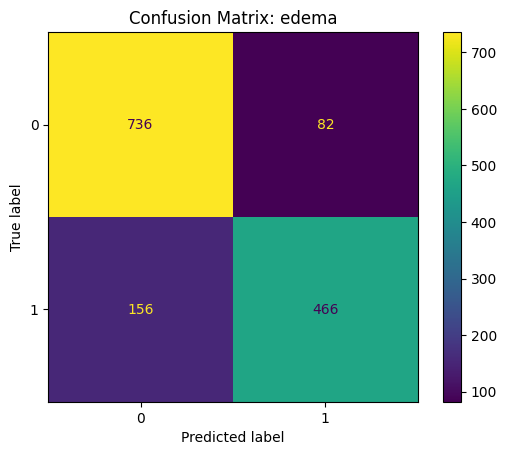

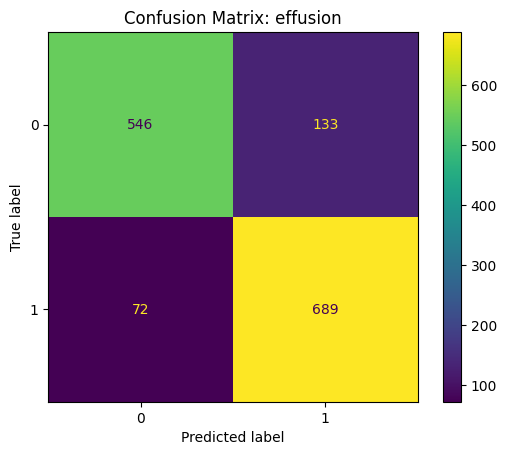

Metrics for dp0.1_wd0_lr1e-05_bs16: {'edema': {'precision': 0.8503649635036497, 'recall': 0.7491961414790996, 'f1': 0.7965811965811965, 'auroc': 0.9110881374853576, 'auprc': 0.8917649545507675, 'sensitivity': 0.7491961414790996, 'specificity': 0.8997555012224939}, 'effusion': {'precision': 0.8381995133819952, 'recall': 0.9053876478318003, 'f1': 0.8704990524320909, 'auroc': 0.9324100720120607, 'auprc': 0.9384489346758536, 'sensitivity': 0.9053876478318003, 'specificity': 0.8041237113402062}}
Running combination: dp0.1_wd0_lr1e-05_bs32


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 1/30: train_loss=0.5579, val_loss=0.4815


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 2/30: train_loss=0.4259, val_loss=0.4383


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 3/30: train_loss=0.3888, val_loss=0.4194


Validation: 100%|██████████| 23/23 [00:43<00:00,  1.88s/it]


Epoch 4/30: train_loss=0.3629, val_loss=0.4081


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 5/30: train_loss=0.3440, val_loss=0.4131


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 6/30: train_loss=0.3319, val_loss=0.3982


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 7/30: train_loss=0.3165, val_loss=0.4274


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 8/30: train_loss=0.3046, val_loss=0.3914


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 9/30: train_loss=0.2963, val_loss=0.4055


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 10/30: train_loss=0.2806, val_loss=0.3986


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 11/30: train_loss=0.2723, val_loss=0.4027


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 12/30: train_loss=0.2580, val_loss=0.3911


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.77s/it]


Epoch 13/30: train_loss=0.2519, val_loss=0.3919


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 14/30: train_loss=0.2350, val_loss=0.4506


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.75s/it]


Epoch 15/30: train_loss=0.2275, val_loss=0.3953


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.76s/it]


Epoch 16/30: train_loss=0.2224, val_loss=0.4041


Validation: 100%|██████████| 23/23 [00:40<00:00,  1.78s/it]

Epoch 17/30: train_loss=0.2062, val_loss=0.4093
Early stopping at epoch 17


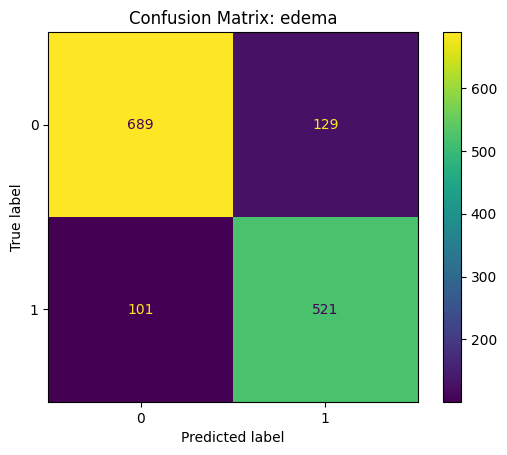

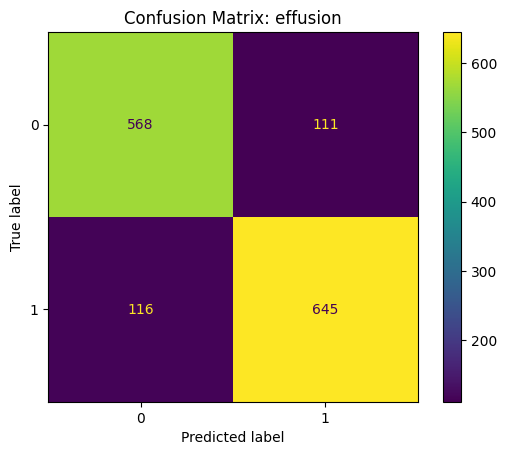

Metrics for dp0.1_wd0_lr1e-05_bs32: {'edema': {'precision': 0.8015384615384615, 'recall': 0.837620578778135, 'f1': 0.8191823899371069, 'auroc': 0.9127292667395185, 'auprc': 0.8874252686295385, 'sensitivity': 0.837620578778135, 'specificity': 0.8422982885085575}, 'effusion': {'precision': 0.8531746031746031, 'recall': 0.8475689881734559, 'f1': 0.8503625576796309, 'auroc': 0.9269912660459553, 'auprc': 0.9279207322708914, 'sensitivity': 0.8475689881734559, 'specificity': 0.8365243004418262}}
Running combination: dp0.1_wd0_lr1e-05_bs64


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Validation: 100%|██████████| 12/12 [00:54<00:00,  4.51s/it]


Epoch 1/30: train_loss=0.5718, val_loss=0.5053


Validation: 100%|██████████| 12/12 [00:51<00:00,  4.25s/it]


Epoch 2/30: train_loss=0.4445, val_loss=0.4573


Validation: 100%|██████████| 12/12 [00:47<00:00,  3.98s/it]


Epoch 3/30: train_loss=0.4084, val_loss=0.4347


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.65s/it]


Epoch 4/30: train_loss=0.3852, val_loss=0.4250


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.66s/it]


Epoch 5/30: train_loss=0.3692, val_loss=0.4176


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.59s/it]


Epoch 6/30: train_loss=0.3513, val_loss=0.4106


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.69s/it]


Epoch 7/30: train_loss=0.3401, val_loss=0.4057


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.68s/it]


Epoch 8/30: train_loss=0.3251, val_loss=0.4085


Validation: 100%|██████████| 12/12 [00:45<00:00,  3.77s/it]


Epoch 9/30: train_loss=0.3138, val_loss=0.3923


Validation: 100%|██████████| 12/12 [00:44<00:00,  3.72s/it]


Epoch 10/30: train_loss=0.3034, val_loss=0.4184


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.64s/it]


Epoch 11/30: train_loss=0.2923, val_loss=0.3941


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.64s/it]


Epoch 12/30: train_loss=0.2861, val_loss=0.3873


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.62s/it]


Epoch 13/30: train_loss=0.2702, val_loss=0.3940


Validation: 100%|██████████| 12/12 [00:42<00:00,  3.58s/it]


Epoch 14/30: train_loss=0.2606, val_loss=0.4116


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.63s/it]


Epoch 15/30: train_loss=0.2606, val_loss=0.4000


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.60s/it]


Epoch 16/30: train_loss=0.2449, val_loss=0.4020


Validation: 100%|██████████| 12/12 [00:43<00:00,  3.63s/it]

Epoch 17/30: train_loss=0.2399, val_loss=0.4099
Early stopping at epoch 17


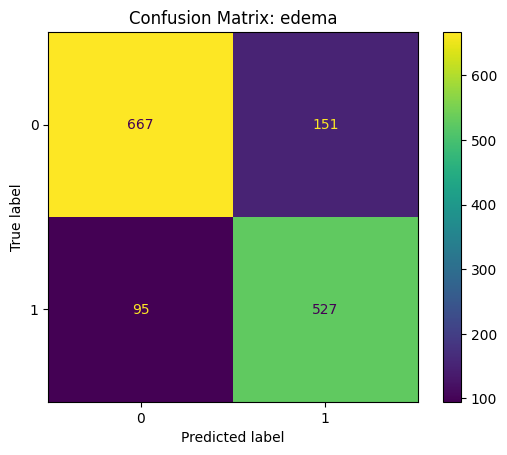

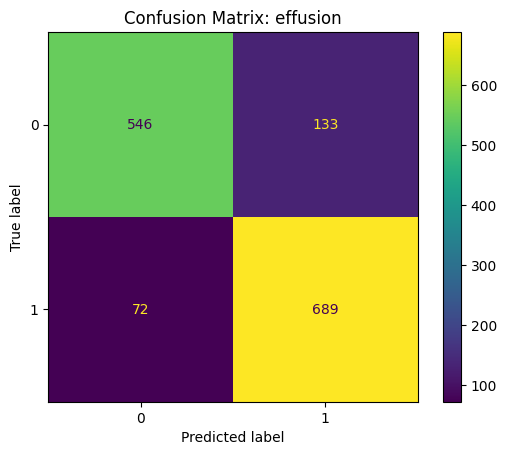

Metrics for dp0.1_wd0_lr1e-05_bs64: {'edema': {'precision': 0.7772861356932154, 'recall': 0.8472668810289389, 'f1': 0.8107692307692308, 'auroc': 0.9126280473903097, 'auprc': 0.8946176313447247, 'sensitivity': 0.8472668810289389, 'specificity': 0.815403422982885}, 'effusion': {'precision': 0.8381995133819952, 'recall': 0.9053876478318003, 'f1': 0.8704990524320909, 'auroc': 0.9287156075158837, 'auprc': 0.9299832572618092, 'sensitivity': 0.9053876478318003, 'specificity': 0.8041237113402062}}


In [19]:
for i in range(0, 3):
    hyperparameters = hyperparameter_combinations[i]
    execute_hyperparameter_combinations(hyperparameters)

In [20]:
# change epochs to 20 to all of them
for i in range(3, len(hyperparameter_combinations)):
    hyperparameters = hyperparameter_combinations[i]
    hyperparameters['num_epochs'] = 20

print(hyperparameter_combinations)

[{'dropout_rate': 0.1, 'weight_decay': 0, 'learning_rate': 1e-05, 'batch_size': 16, 'num_epochs': 30}, {'dropout_rate': 0.1, 'weight_decay': 0, 'learning_rate': 1e-05, 'batch_size': 32, 'num_epochs': 30}, {'dropout_rate': 0.1, 'weight_decay': 0, 'learning_rate': 1e-05, 'batch_size': 64, 'num_epochs': 30}, {'dropout_rate': 0.1, 'weight_decay': 0, 'learning_rate': 5e-05, 'batch_size': 16, 'num_epochs': 20}, {'dropout_rate': 0.1, 'weight_decay': 0, 'learning_rate': 5e-05, 'batch_size': 32, 'num_epochs': 20}, {'dropout_rate': 0.1, 'weight_decay': 0, 'learning_rate': 5e-05, 'batch_size': 64, 'num_epochs': 20}, {'dropout_rate': 0.1, 'weight_decay': 0, 'learning_rate': 0.0002, 'batch_size': 16, 'num_epochs': 20}, {'dropout_rate': 0.1, 'weight_decay': 0, 'learning_rate': 0.0002, 'batch_size': 32, 'num_epochs': 20}, {'dropout_rate': 0.1, 'weight_decay': 0, 'learning_rate': 0.0002, 'batch_size': 64, 'num_epochs': 20}, {'dropout_rate': 0.1, 'weight_decay': 0.01, 'learning_rate': 1e-05, 'batch_siz

In [ ]:
for i in range(3, 6):
    hyperparameters = hyperparameter_combinations[i]
    execute_hyperparameter_combinations(hyperparameters)